In [8]:
#REF to 
# http://pinkwink.kr/1003#recentComments
# http://folium.readthedocs.io/en/latest/quickstart.html
# https://financedata.github.io/posts/matplotlib-hangul-for-ubuntu-linux.html
# http://python-visualization.github.io/folium/docs-v0.5.0/
import numpy as np
import pandas as pd
import seaborn as sns

In [9]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

In [10]:
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['font.size'] = 12.
plt.rcParams['xtick.labelsize'] = 12.
plt.rcParams['ytick.labelsize'] = 12.
plt.rcParams['axes.labelsize'] = 12.

In [11]:
SeoulGu_name = {'서대문': '서대문구', '수서': '강남구', '강서': '강서구', '서초': '서초구',
                '서부': '은평구', '중부': '중구', '종로': '종로구', '남대문': '중구',
                '혜화': '종로구', '용산': '용산구', '성북': '성북구', '동대문': '동대문구',
                '마포': '마포구', '영등포': '영등포구', '성동': '성동구', '동작': '동작구',
                '광진': '광진구', '강북': '강북구', '금천': '금천구', '중랑': '중랑구',
                '강남': '강남구', '관악': '관악구', '강동': '강동구', '종암': '성북구', 
                '구로': '구로구', '양천': '양천구', '송파': '송파구', '노원': '노원구', 
                '방배': '서초구', '은평': '은평구', '도봉': '도봉구'}

In [12]:
df=pd.read_csv("2016.csv", encoding="EUC-KR")

In [13]:
df['구별']=df['구분'].apply(lambda v: SeoulGu_name.get(v,v))
p_df=df.pivot_table(index=['구별','죄종','발생검거'])


In [14]:
usp_df=p_df.unstack().unstack()
udf=usp_df['건수']['발생']
popDF = pd.read_csv('pop_kor.csv', encoding="UTF-8", index_col="구별")

In [15]:
udf=udf.join(popDF)

In [16]:
for i in udf.columns[:-1] :
    udf[i]=(udf[i]/udf['인구수'])*1000000
    
for i in udf.columns[:-1] :
    udf[i] = udf[i].apply(lambda x : x/udf[i].max())

In [17]:
del udf['인구수']

In [18]:
total=udf.sum(axis=1)

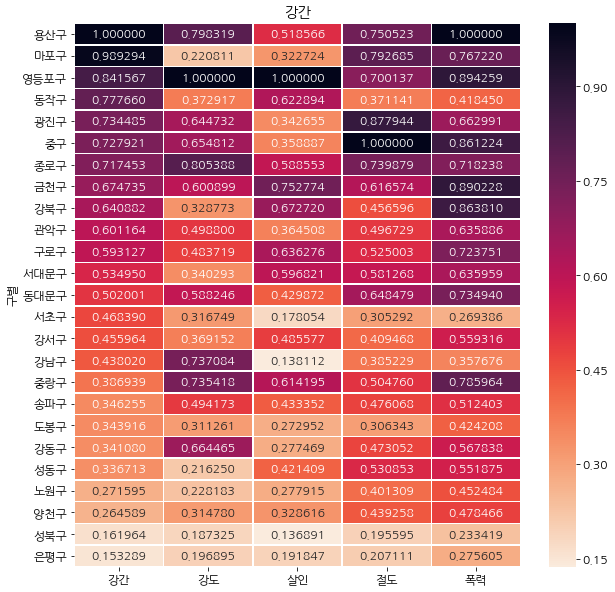

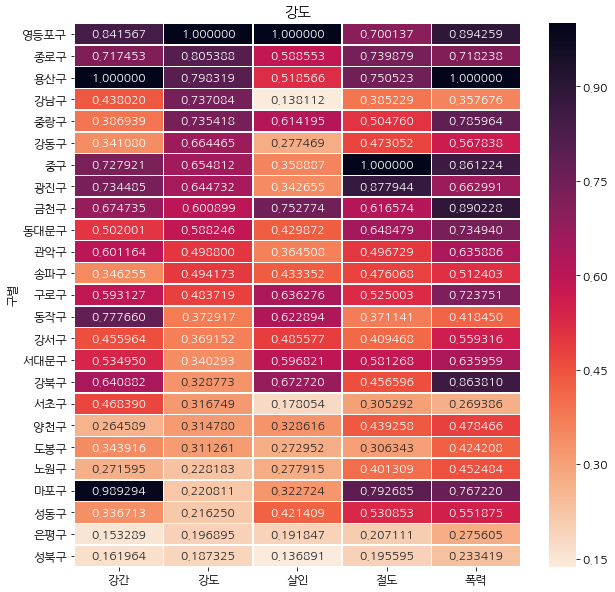

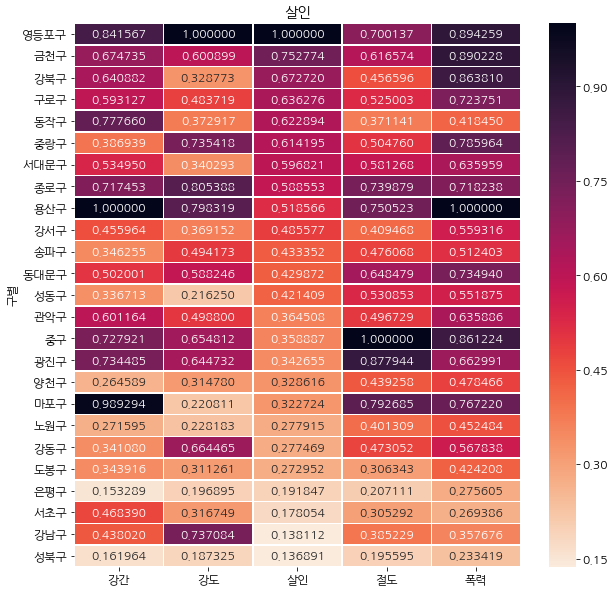

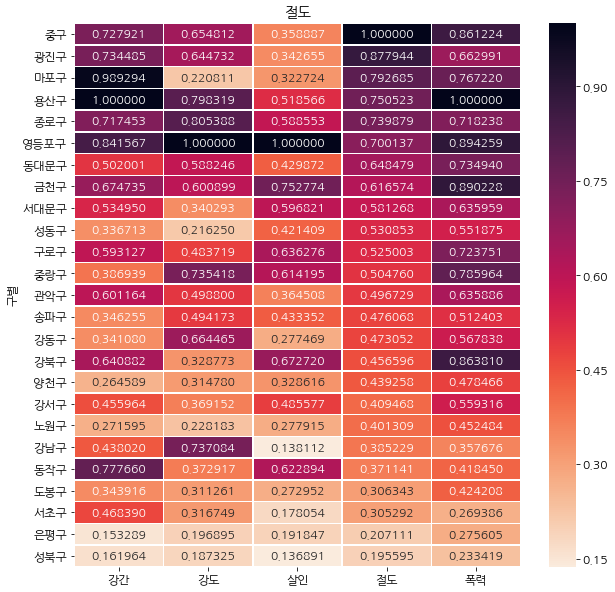

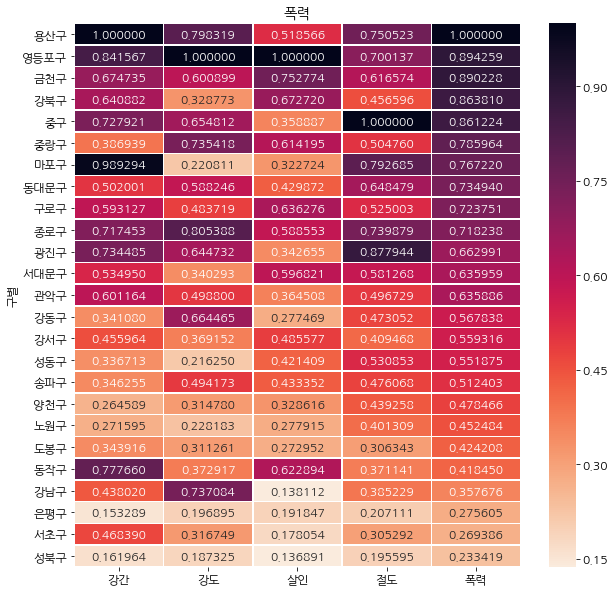

In [19]:
cmap = sns.cm.rocket_r

for i in udf.columns :    
    plt.figure(figsize=(10,10))
    sns.heatmap(udf.sort_values(by=i, ascending=False), annot=True, fmt='f', linewidths=.5, cmap=cmap)
    plt.title(i)
    plt.show()

In [20]:
import json
import folium
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

geo_path = 'skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

In [21]:
station_name=("서울" + df['구분'] + "경찰서").unique()

In [22]:
import googlemaps
gmaps = googlemaps.Client(key=open('google.key').readline())

lat = []
lng = []

for name in station_name:
    tmpMap = gmaps.geocode(name)
    tmpLoc = tmpMap[0].get('geometry')
    lat.append(tmpLoc['location']['lat'])
    lng.append(tmpLoc['location']['lng'])  


In [23]:
rate=df.pivot_table(index=['구분','발생검거']).unstack()['건수']
rate['검거율']=round(rate['검거']/rate['발생']*100,2)

In [24]:
df2=pd.DataFrame(data=[station_name,lat,lng]).transpose().sort_values(by=0)
df2.index=rate.index
df2.columns=['name','lat','lng']
df2['performance'] = rate['검거율']
df2['performance']=(df2['performance'] - df2['performance'].min())/(df2['performance'].max()-df2['performance'].min())

In [25]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11)


map.choropleth(geo_data = geo_str,
               data = udf['살인'],
               columns = [udf.index, udf['살인']],
               fill_color = 'PuRd', #PuRd, YlGnBu
               key_on = 'feature.id')



for n in df2.index:    
    #print (df2['lat'][n], df2['lng'][n], df2['performance'][n]*25)
    folium.CircleMarker([df2['lat'][n], df2['lng'][n]], 
                        radius=df2['performance'][n]*30, 
                        color="#3186cc", 
                        fill_color="#3186cc",
                        fill=True
                       ).add_to(map)      

map